In [2]:
import librosa
import scipy
import numpy as np
import matplotlib.pyplot as plt
from notebook_utils import get_audio_list
import sys
sys.path.append('/home/martin/tesis/inverse_filter_deepdereverb/')
from utils import *
from data.funciones import *

In [3]:
RIR_PATH = '/home/martin/datasets/rir/C4DM/classroom'
SPEECH_PATH = '/home/martin/datasets/speech/LibriSpeech'
SAVE_PATH='/home/martin/tesis/inverse_filter_deepdereverb/npy_data/'
Q_e = 32
LM = 5
Pd = 9

In [4]:
rir_list = get_audio_list(RIR_PATH)
speech_list = get_audio_list(SPEECH_PATH)

(0.0, 500.0)

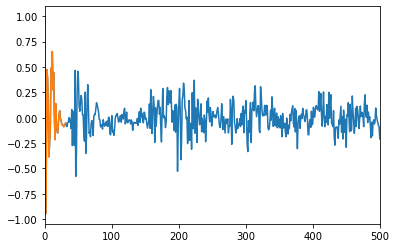

In [5]:
#generar espectrogramas de mismas dimenciones
rir, fs_rir = librosa.load(rir_list[0], sr=16000)
speech, fs_speech = librosa.load(speech_list[0], sr=16000)
assert fs_rir == fs_speech

#Corto el delay y normalizo el impulso
rir = rir[np.argmax(abs(rir)):]/rir[np.argmax(abs(rir))]
rir_early = rir[:Q_e]

plt.plot(rir)
plt.plot(rir_early)
plt.xlim(0,500)

In [10]:
#Convoluciono y limito al largo del speech
reverb = scipy.signal.fftconvolve(speech, rir)[:len(speech)]
early_reverb = scipy.signal.fftconvolve(speech, rir_early)[:len(speech)]

#Calculos los espectro STFT y me quedo con el modulo
reverb_spec = librosa.stft(reverb, n_fft=512, hop_length=160, win_length=400, window=scipy.signal.windows.hamming)[:-1, :]
early_reverb_spec = librosa.stft(early_reverb, n_fft=512, hop_length=160, win_length=400, window=scipy.signal.windows.hamming)[:-1,:]
assert reverb_spec.shape == early_reverb_spec.shape
reverb_spec = abs(reverb_spec)
early_reverb_spec = abs(early_reverb_spec)

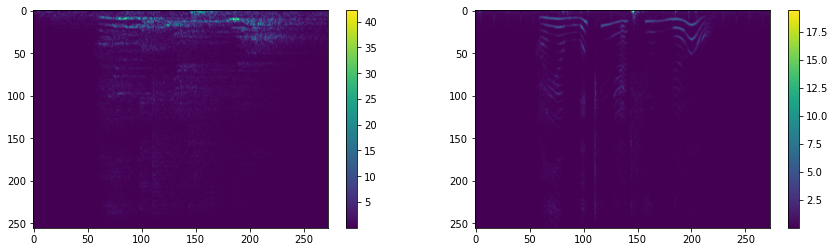

In [11]:
plt.subplot(1,2,1)
plt.imshow(reverb_spec, aspect='auto')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(early_reverb_spec, aspect='auto')
plt.colorbar()
plt.subplots_adjust(right=2)

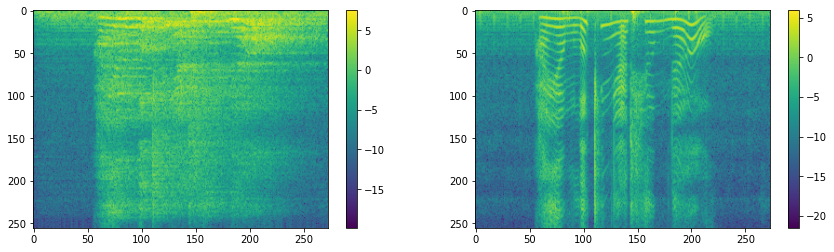

In [12]:
plt.subplot(1,2,1)
plt.imshow(np.log(reverb_spec**2+EPS), aspect='auto')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.log(early_reverb_spec**2+EPS), aspect='auto')
plt.colorbar()
plt.subplots_adjust(right=2)

Para determinar si hacer o no y donde hacer la normalizacion, puedo dejar para hacerlo en el data loader, que es el ultimo paso antes de entrar a la red. Por lo que dice el paper, la input A (que entra a la red) se le deberia calcular el LPS y al resto solo se deberia trabajar con el modulo del espectrograma complejo, como se ven en las imagenes de aca arriba.

In [15]:
#formacion de las imputs
n_frames = np.arange(reverb_spec.shape[1])
valid_frames = n_frames[Pd-1:int(-((LM-1)/2)-1)]

# input_A ---> Lo que entra a la red
# input B ---> time-shifted para convolucion final
# output  ---> frame objetivo del espectro early
inputs_A = []
inputs_B = []
outputs = []
for l in valid_frames:
    input_A = reverb_spec[:, int(l-((LM-1)/2)):int(l+((LM-1)/2)+1)]
    input_A = normalise(np.log(input_A**2))
    input_B = reverb_spec[:, l-Pd+1:l+1]
    output = early_reverb_spec[:, l]
    inputs_A.append(input_A)
    inputs_B.append(input_B)
    outputs.append(output)

Input A shape: (256, 5)
Input B shape: (256, 9)
Output shape: (256,)


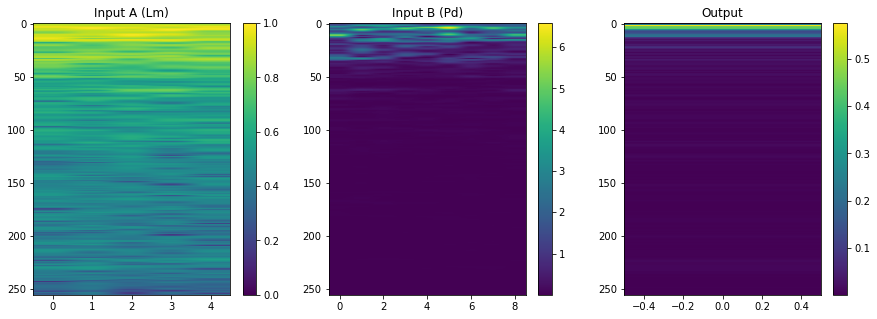

In [16]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

axs[0].set_title('Input A (Lm)')
im1 = axs[0].imshow(input_A, aspect='auto')
fig.colorbar(im1, ax=axs[0])

axs[1].set_title('Input B (Pd)')
im2 = axs[1].imshow(input_B, aspect='auto')
fig.colorbar(im2, ax=axs[1])

axs[2].set_title('Output')
im3 = axs[2].imshow(output.reshape(-1,1), aspect='auto')
fig.colorbar(im3, ax=axs[2])

print('Input A shape: '+str(input_A.shape))
print('Input B shape: '+str(input_B.shape))
print('Output shape: '+str(output.shape))

In [17]:
prueba = np.hstack((input_A, input_B, output.reshape(-1,1)))
input_Ap = prueba[:, :LM]
input_Bp = prueba[:, LM:LM+Pd]
output_p = prueba[:, -1:].reshape(256)

In [23]:
(input_A==input_Ap).all() & (input_B==input_Bp).all() & (output==output_p).all()

True

In [26]:
#Pipeline para un solo par de speech-rir
contador = 0
reverb_spec, early_reverb_spec = generate_specs(rir_list[0], speech_list[0], Q_e)
generate_inputs(reverb_spec, early_reverb_spec,LM, Pd, contador, 'tmp/')

In [29]:
def load_npy(path):
    input_A = np.empty((1, 256, 5, 1))                                                                                
    input_B = np.empty((1, 256, 9, 1))                                                                                
    output = np.empty((1, 256, 1))                                                                                    
    saved_array = np.empty((256,15))                                                                                       
    LM = 5                                                                                                                          
    Pd = 9                                                                                                                          
    # Generate data                                                                                                                 

    saved_array = np.load(path)                                                                         
    input_A = saved_array[:, :LM].reshape(1,256, LM,1)                                                                         
    input_B = saved_array[:,LM:LM+Pd].reshape(1,256, Pd, 1)                                                                    
    output = saved_array[:, -1:].reshape(1,256,1)                                                                              

    return [input_A, input_B], output
[input_A, input_B], output = load_npy('tmp/100.npy')

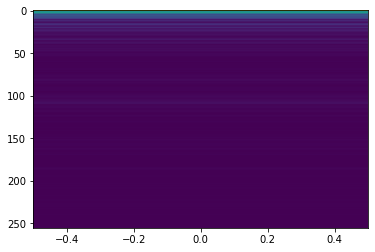

In [30]:
plt.imshow(output.reshape(256,-1), aspect='auto')